In [48]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [49]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [50]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

In [51]:
%%R
df.l2fc.OM = read.table('data/l2fc_sparse-maxRejH_bulk_OM.txt', sep='\t', header = TRUE)

In [52]:
%%R
df.l2fc.Till = read.table('data/l2fc_Till.txt', sep='\t', header = TRUE)

In [53]:
%%R
df.l2fc.Moist = read.table('data/l2fc_Moist_allSamples.txt', sep='\t', header = TRUE)

In [54]:
%%R
df.l2fc.Temp = read.table('data/l2fc_Temp.txt', sep='\t', header = TRUE)

In [55]:
%%R
df.l2fc.AugNov = read.table('data/l2fc_sparse-maxRejH_AugNov.txt', sep='\t', header = TRUE)
df.l2fc.AugAp = read.table('data/l2fc_sparse-maxRejH_AugApril.txt', sep='\t', header = TRUE)

In [56]:
%%R
df.l2fc.OM = plyr::rename(df.l2fc.OM, c("log2FoldChange" = "LFC_OM"))
df.l2fc.OM = plyr::rename(df.l2fc.OM, c("padj2" = "p_OM"))

df.l2fc.Till = plyr::rename(df.l2fc.Till, c("log2FoldChange" = "LFC_Till"))
df.l2fc.Till = plyr::rename(df.l2fc.Till, c("padj2" = "p_Till"))

df.l2fc.Moist = plyr::rename(df.l2fc.Moist, c("log2FoldChange" = "LFC_Moist"))
df.l2fc.Moist = plyr::rename(df.l2fc.Moist, c("padj2" = "p_Moist"))

df.l2fc.Temp = plyr::rename(df.l2fc.Temp, c("log2FoldChange" = "LFC_Temp"))
df.l2fc.Temp = plyr::rename(df.l2fc.Temp, c("padj2" = "p_Temp"))

df.l2fc.AugNov = plyr::rename(df.l2fc.AugNov, c("log2FoldChange" = "LFC_AugNov"))
df.l2fc.AugNov = plyr::rename(df.l2fc.AugNov, c("padj2" = "p_AugNov"))

df.l2fc.AugAp = plyr::rename(df.l2fc.AugAp, c("log2FoldChange" = "LFC_AugAp"))
df.l2fc.AugAp = plyr::rename(df.l2fc.AugAp, c("padj2" = "p_AugAp"))

print(head(df.l2fc.OM, n = 2))
print(head(df.l2fc.Till, n = 2))
print(head(df.l2fc.Moist, n = 2))
print(head(df.l2fc.Temp, n = 2))

  X sparsity_threshold      OTU     LFC_OM     lfcSE      padj    Rank1
1 1               0.05 OTU.6089 -0.9801378 0.9119983 0.5078156 k__Fungi
2 2               0.05 OTU.6711  0.6570815 0.7369292 0.5969405 k__Fungi
            Rank2           Rank3           Rank4           Rank5
1 p__unidentified c__unidentified o__unidentified f__unidentified
2 p__unidentified c__unidentified o__unidentified f__unidentified
            Rank6       Rank7      p_OM        OM
1 g__unidentified s__Fungi sp 0.6930457 Harvested
2 g__unidentified s__Fungi sp 0.7566937  Returned
  sparsity_threshold      OTU  LFC_Till     lfcSE         padj    Rank1
1               0.05 OTU.6089 -2.522226 0.9178653 0.0142123606 k__Fungi
2               0.05 OTU.6711  2.881276 0.7240328 0.0002447177 k__Fungi
            Rank2           Rank3           Rank4           Rank5
1 p__unidentified c__unidentified o__unidentified f__unidentified
2 p__unidentified c__unidentified o__unidentified f__unidentified
            Rank6     

In [57]:
%%R
df.O = select(df.l2fc.OM, -padj,- sparsity_threshold, -lfcSE)
df.T = select(df.l2fc.Till, -padj, - sparsity_threshold, -lfcSE)

OM.till = full_join(df.O, df.T)

OM.till$Rank2 = gsub("p__", "", OM.till$Rank2)
OM.till$Rank3 = gsub("c__", "", OM.till$Rank3)

head(OM.till)

  X      OTU     LFC_OM    Rank1         Rank2          Rank3           Rank4
1 1 OTU.6089 -0.9801378 k__Fungi  unidentified   unidentified o__unidentified
2 2 OTU.6711  0.6570815 k__Fungi  unidentified   unidentified o__unidentified
3 3 OTU.2605  1.6193454 k__Fungi  unidentified   unidentified o__unidentified
4 4 OTU.6041 -0.6267623 k__Fungi Basidiomycota Agaricomycetes   o__Agaricales
5 5 OTU.6291 -1.2644476 k__Fungi Basidiomycota Agaricomycetes   o__Agaricales
6 6 OTU.9364  1.3375805 k__Fungi Basidiomycota Agaricomycetes    o__Boletales
            Rank5           Rank6       Rank7      p_OM        OM   LFC_Till
1 f__unidentified g__unidentified s__Fungi sp 0.6930457 Harvested -2.5222263
2 f__unidentified g__unidentified s__Fungi sp 0.7566937  Returned  2.8812759
3 f__unidentified g__unidentified s__Fungi sp 0.0511690  Returned  1.8032284
4  f__Agaricaceae   g__Lycoperdon        <NA> 0.8044192 Harvested -0.4527828
5  f__Agaricaceae   g__Lycoperdon        <NA> 0.3309419 Harvested  0.

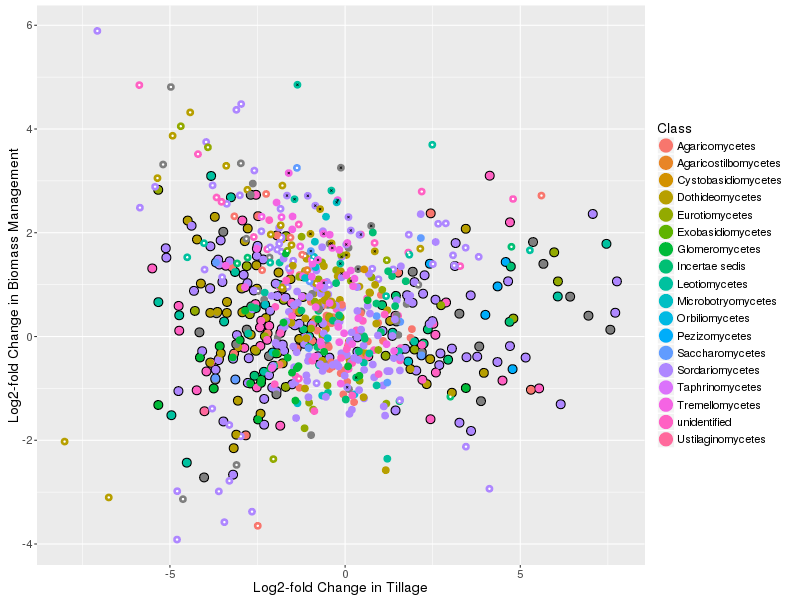

In [58]:
%%R -w 800 -h 600
resp = OM.till %>% filter(p_Till  <=0.10 & p_OM  <=0.10)
resp.Till = OM.till %>% filter(p_Till  <=0.10 & p_OM  >0.10)
resp.OM = OM.till %>% filter(p_Till  > 0.10 & p_OM  <=0.10)

p = ggplot(data = OM.till, aes(x = LFC_Till, y = LFC_OM, color = Rank3)) +
    geom_point(data = resp.Till, color = 'black', size = 4) +
    geom_point(size = 3) +
    geom_point(data = resp, color = 'white', size = .5) +
    
    geom_point(data = resp.OM, color = 'black', size = .5, shape = 4) 
p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('Log2-fold Change in Tillage') + 
        ylab('Log2-fold Change in Biomass Management') + scale_color_discrete(name = 'Class')

p

In [59]:
%%R
full_l2fc = full_join(df.l2fc.Till, df.l2fc.OM, by = "OTU", "Land_Management")
full_l2fc = full_l2fc %>% select(OTU, p_Till, Till, LFC_Till, LFC_OM, p_OM, OM)

full_l2fc = full_join(full_l2fc, df.l2fc.Temp, by = c("OTU"))
full_l2fc = full_l2fc %>% select(OTU, p_Till, Till, LFC_Till, LFC_OM, p_OM, OM, LFC_Temp, p_Temp, 
                                Temp, Land_Management)

full_l2fc = full_join(full_l2fc, df.l2fc.Moist, by = c("OTU", "Land_Management"))
full_l2fc = full_l2fc %>% select(OTU, p_Till, Till, LFC_Till, LFC_OM, p_OM, OM, LFC_Temp, p_Temp, 
                                Temp, LFC_Moist, p_Moist, Land_Management)

full_l2fc = full_join(full_l2fc, df.l2fc.AugNov, by = c("OTU", "Land_Management"))
full_l2fc = full_l2fc %>% select(OTU, p_Till, Till, LFC_Till, LFC_OM, p_OM, OM, LFC_Temp, p_Temp, 
                                Temp, LFC_OM, p_OM,LFC_Moist, p_Moist, LFC_AugNov, p_AugNov, Land_Management)

full_l2fc = full_join(full_l2fc, df.l2fc.AugAp, by = c("OTU", "Land_Management"))

In [60]:
%%R

full_l2fc$Rank2 = gsub("p__", "", full_l2fc$Rank2)
full_l2fc$Rank3 = gsub("c__", "", full_l2fc$Rank3)
full_l2fc$Rank4 = gsub("o__", "", full_l2fc$Rank4)
full_l2fc$Rank5 = gsub("f__", "", full_l2fc$Rank5)
full_l2fc$Rank6 = gsub("g__", "", full_l2fc$Rank6)
full_l2fc$Rank7 = gsub("s__", "", full_l2fc$Rank7)

head(full_l2fc)

       OTU       p_Till Till  LFC_Till     LFC_OM      p_OM        OM
1 OTU.6089 0.0240476305    N -2.522226 -0.9801378 0.6930457 Harvested
2 OTU.6711 0.0005310709    T  2.881276  0.6570815 0.7566937  Returned
3 OTU.6711 0.0005310709    T  2.881276  0.6570815 0.7566937  Returned
4 OTU.2605 0.0057572879    T  1.803228  1.6193454 0.0511690  Returned
5 OTU.2605 0.0057572879    T  1.803228  1.6193454 0.0511690  Returned
6 OTU.2605 0.0057572879    T  1.803228  1.6193454 0.0511690  Returned
      LFC_Temp    p_Temp       Temp   LFC_Moist   p_Moist LFC_AugNov p_AugNov
1  0.084353754 0.9999868 increasing          NA        NA         NA       NA
2 -0.024935924 0.9999868 decreasing          NA        NA         NA       NA
3  0.085695180 0.9999868 increasing          NA        NA         NA       NA
4 -0.042157153 0.9999868 decreasing          NA        NA         NA       NA
5 -0.002682863 0.9999868 decreasing          NA        NA         NA       NA
6 -0.018348945 0.9999868 decreasing -0.083

In [102]:
%%R
filter(full_l2fc, p_AugNov <=0.10 & LFC_AugNov < 0 & p_Moist <= 0.10) %>% group_by(Land_Management, Rank3) %>% 
        summarise(nOTU = n())

Source: local data frame [2 x 3]
Groups: Land_Management [?]

  Land_Management           Rank3  nOTU
           (fctr)           (chr) (int)
1             NTR Dothideomycetes     1
2             NTR    unidentified     1


In [62]:
%%R
filter(full_l2fc, p_AugNov <=0.10 & LFC_AugNov < 0 & p_Temp <= 0.10) %>% group_by(Land_Management) %>% 
        summarise(nOTU = n())

Source: local data frame [3 x 2]

  Land_Management  nOTU
           (fctr) (int)
1             NTH     1
2             NTR    15
3             PTR     1


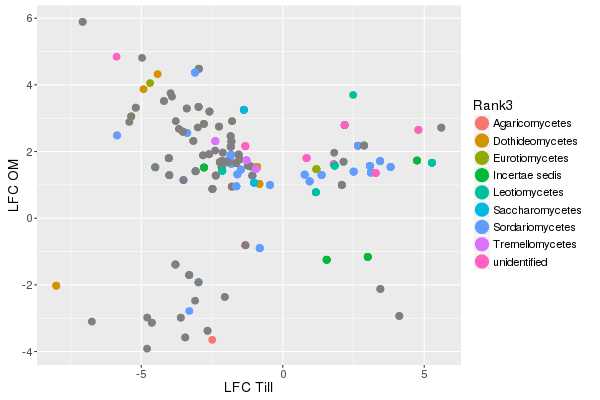

In [63]:
%%R -w 600 -h 400
resp = full_l2fc %>% filter(p_Till  <=0.10 & p_OM  <=0.10)
p = ggplot(data = resp, aes(x = LFC_Till, y = LFC_OM, color = Rank3)) + geom_point(size = 3) 
p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('LFC Till') + ylab('LFC OM')

p

In [64]:
%%R
print(length(resp$OTU))

NTR = filter(resp, Till == 'N' & OM == 'Returned')
print(length(NTR$OTU))

PTR = filter(resp, Till == 'T' & OM == 'Returned')
print(length(PTR$OTU))

NTH = filter(resp, Till == 'N' & OM == 'Harvested')
print(length(NTH$OTU))

PTH = filter(resp, Till == 'T' & OM == 'Harvested')
print(length(PTH$OTU))



[1] 343
[1] 210
[1] 83
[1] 38
[1] 12


In [65]:
%%R
head(resp)

       OTU       p_Till Till  LFC_Till   LFC_OM        p_OM       OM
1 OTU.2605 5.757288e-03    T  1.803228 1.619345 0.051168999 Returned
2 OTU.2605 5.757288e-03    T  1.803228 1.619345 0.051168999 Returned
3 OTU.2605 5.757288e-03    T  1.803228 1.619345 0.051168999 Returned
4 OTU.4807 3.826114e-03    N -2.253521 2.748352 0.001272472 Returned
5 OTU.4807 3.826114e-03    N -2.253521 2.748352 0.001272472 Returned
6 OTU.1259 5.156597e-06    N -3.160882 2.318270 0.008372391 Returned
      LFC_Temp    p_Temp       Temp   LFC_Moist   p_Moist   LFC_AugNov p_AugNov
1 -0.042157153 0.9999868 decreasing          NA        NA           NA       NA
2 -0.002682863 0.9999868 decreasing          NA        NA           NA       NA
3 -0.018348945 0.9999868 decreasing -0.08389886 0.9992961 -1.017788289        1
4 -0.054486500 0.9999868 decreasing          NA        NA           NA       NA
5 -0.158452496 0.8679766 decreasing          NA        NA -0.003562472        1
6  0.033639613 0.9999868 increasing  

In [66]:
%%R
ggsave(filename = "data/figs/OTUs_OMTill.png", plot = p, width =6, height =4)

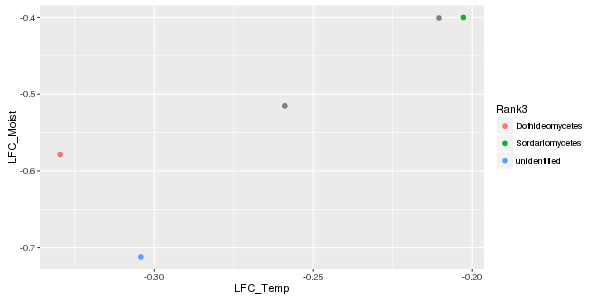

In [103]:
%%R -w 600 -h 300
resp = full_l2fc %>% filter(p_Moist  <=0.10 & p_Temp  <=0.10)
ggplot(data = resp, aes(x = LFC_Temp, y = LFC_Moist, color = Rank3)) + geom_point(size = 2) #+
        #facet_wrap(~Land_Management)

In [104]:
%%R
resp

        OTU       p_Till Till   LFC_Till   LFC_OM       p_OM       OM
1   OTU.227 9.828002e-19    T  3.8134124 1.536571 0.01824790 Returned
2   OTU.692 9.988464e-10    N -4.0281307 1.799686 0.07775431 Returned
3   OTU.549 9.945148e-02    N -1.1997341 1.163638 0.24738972 Returned
4    OTU.26 1.869087e-01    N -0.6074730 1.034843 0.05116900 Returned
5 OTU.37716 2.279873e-02    N -0.8270377 1.027154 0.01662765 Returned
    LFC_Temp       p_Temp       Temp  LFC_Moist      p_Moist LFC_AugNov
1 -0.2027647 3.017736e-03 decreasing -0.3999400 0.0285411026  -1.925024
2 -0.2589236 3.112007e-04 decreasing -0.5151783 0.0085278387  -3.976577
3 -0.2104432 3.017736e-03 decreasing -0.4006700 0.0298316102  -4.165216
4 -0.3042180 1.569960e-06 decreasing -0.7122160 0.0000557225  -3.938830
5 -0.3296098 3.182138e-14 decreasing -0.5786605 0.0031059489  -4.408422
     p_AugNov Land_Management sparsity_threshold  LFC_AugAp     lfcSE
1 1.000000000             PTH                0.4 -0.1504758 0.8228473
2 0.4567

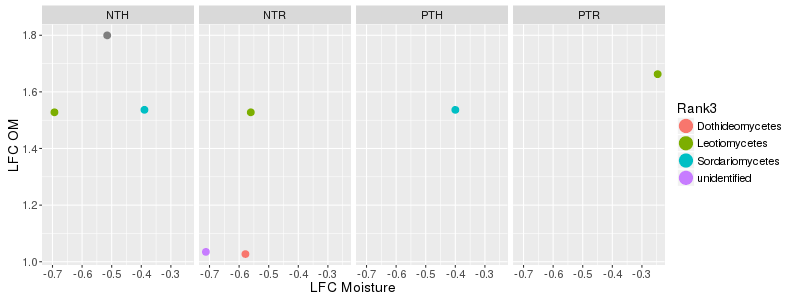

In [68]:
%%R -w 800 -h 300

resp = full_l2fc %>% filter(p_OM <=0.10 & p_Moist <=0.10)
p = ggplot(data = resp, aes(x = LFC_Moist, y = LFC_OM, color = Rank3)) + geom_point(size = 3) +
        facet_grid(~Land_Management)

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('LFC Moisture') + ylab('LFC OM')

p

In [69]:
%%R
print(length(resp$OTU))
print(length(unique(resp$OTU)))

[1] 8
[1] 7


In [70]:
%%R
ggsave(filename = "data/figs/OTUs_OMMoist.png", plot = p, width =12, height =4)

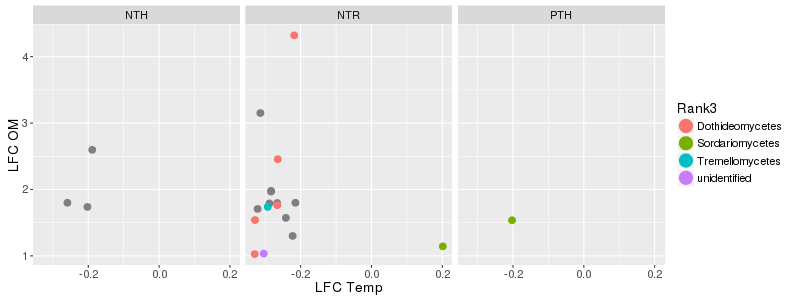

In [71]:
%%R -w 800 -h 300

resp = full_l2fc %>% filter(p_OM <=0.10 & p_Temp <=0.10)
p = ggplot(data = resp, aes(x = LFC_Temp, y = LFC_OM, color = Rank3)) + geom_point(size = 3) +
        facet_grid(~Land_Management)

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('LFC Temp') + ylab('LFC OM')

p

In [72]:
%%R
print(length(resp$OTU))
print(length(unique(resp$OTU)))

[1] 21
[1] 19


In [73]:
%%R
ggsave(filename = "data/figs/OTUs_OMTemp.png", plot = p, width =12, height =4)

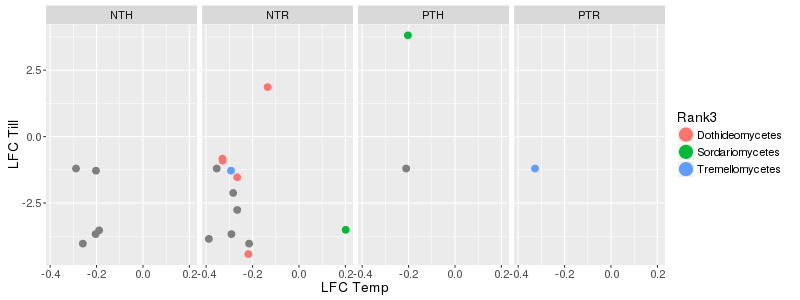

In [74]:
%%R -w 800 -h 300

resp = full_l2fc %>% filter(p_Till <=0.10 & p_Temp <=0.10)
p = ggplot(data = resp, aes(x = LFC_Temp, y = LFC_Till, color = Rank3)) + geom_point(size = 3) +
        facet_grid(~Land_Management)

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('LFC Temp') + ylab('LFC Till')

p

In [75]:
%%R
print(length(resp$OTU))
print(length(unique(resp$OTU)))

[1] 21
[1] 15


In [76]:
%%R
ggsave(filename = "data/figs/OTUs_TillTemp.png", plot = p, width =12, height =4)

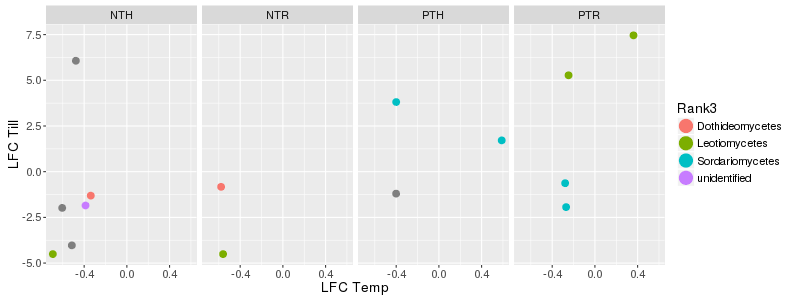

In [77]:
%%R -w 800 -h 300

resp = full_l2fc %>% filter(p_Till <=0.10 & p_Moist <=0.10)
p = ggplot(data = resp, aes(x = LFC_Moist, y = LFC_Till, color = Rank3)) + geom_point(size = 3) +
        facet_grid(~Land_Management)

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('LFC Temp') + ylab('LFC Till')

p

In [78]:
%%R
print(length(resp$OTU))
print(length(unique(resp$OTU)))

[1] 15
[1] 14


In [79]:
%%R
ggsave(filename = "data/figs/OTUs_MoistTill.png", plot = p, width =12, height =4)

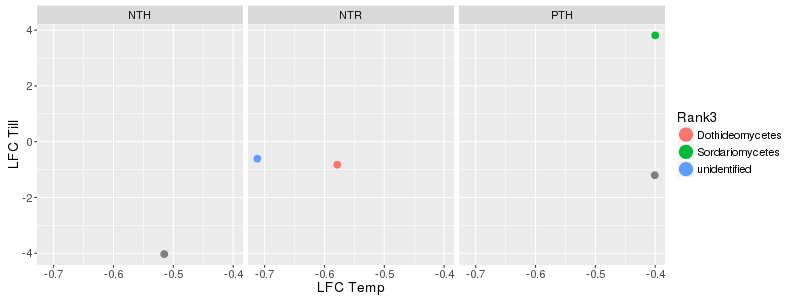

In [80]:
%%R -w 800 -h 300

resp = full_l2fc %>% filter(p_Temp <=0.10 & p_Moist <=0.10)
p = ggplot(data = resp, aes(x = LFC_Moist, y = LFC_Till, color = Rank3)) + geom_point(size = 3) +
        facet_grid(~Land_Management)

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14)) + xlab('LFC Temp') + ylab('LFC Till')

p

In [81]:
%%R
print(length(resp$OTU))
print(length(unique(resp$OTU)))

[1] 5
[1] 5


In [82]:
%%R
filter(resp, Land_Management == 'PTR')

 [1] OTU                p_Till             Till               LFC_Till          
 [5] LFC_OM             p_OM               OM                 LFC_Temp          
 [9] p_Temp             Temp               LFC_Moist          p_Moist           
[13] LFC_AugNov         p_AugNov           Land_Management    sparsity_threshold
[17] LFC_AugAp          lfcSE              padj               Rank1             
[21] Rank2              Rank3              Rank4              Rank5             
[25] Rank6              Rank7              p_AugAp            Month             
<0 rows> (or 0-length row.names)


In [83]:
%%R
ggsave(filename = "data/figs/OTUs_OMTemp.png", plot = p, width =12, height =4)

In [84]:
%%R
filter(resp, OTU == 'OTU.2624')

 [1] OTU                p_Till             Till               LFC_Till          
 [5] LFC_OM             p_OM               OM                 LFC_Temp          
 [9] p_Temp             Temp               LFC_Moist          p_Moist           
[13] LFC_AugNov         p_AugNov           Land_Management    sparsity_threshold
[17] LFC_AugAp          lfcSE              padj               Rank1             
[21] Rank2              Rank3              Rank4              Rank5             
[25] Rank6              Rank7              p_AugAp            Month             
<0 rows> (or 0-length row.names)


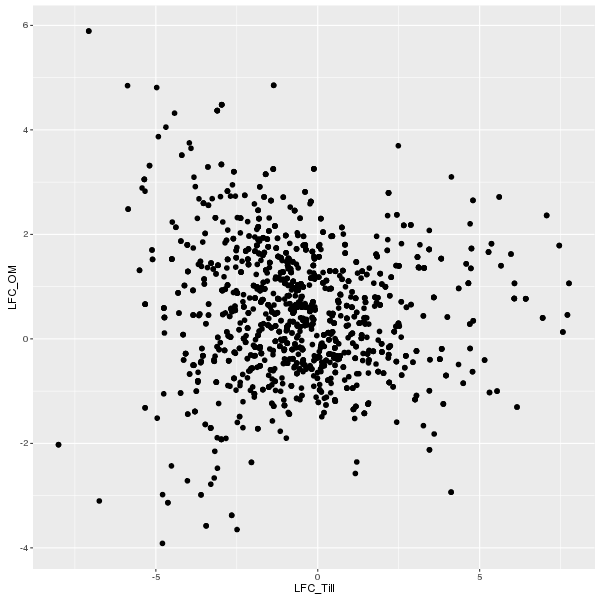

In [85]:
%%R -w 600 -h 600
ggplot(data = full_l2fc, aes(x = LFC_Till, y = LFC_OM)) + geom_point(size = 2)

In [86]:
%%R -w 600 -h 600
ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_Till)) + geom_point(size = 2)


Error in ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_Till)) : 
  object 'full_l2fc_2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_Till)) : 
  object 'full_l2fc_2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In outer_join_impl(x, y, by$x, by$y) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/rob

In [87]:
%%R -w 600 -h 600
ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_OM, shape = Resp_status_Till)) +
        geom_point(size = 3)


Error in ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_OM,  : 
  object 'full_l2fc_2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_OM,  : 
  object 'full_l2fc_2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [88]:
%%R -w 800 -h 600

full_l2fc_2$Resp_status_total = paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM, sep = '_')

ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_total)) + geom_point(size = 2) +
    theme(
        text = element_text(size=14),
        axis.title.y = element_text(vjust=1)
        )


Error in paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM,  : 
  object 'full_l2fc_2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM,  : 
  object 'full_l2fc_2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [89]:
%%R -w 1000 -h 600

full_l2fc_2$Resp_status_total = paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM, sep = '_')

ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Rank4.x)) + geom_point(size = 3) +
    theme(
        text = element_text(size=14),
        axis.title.y = element_text(vjust=1)
        )


Error in paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM,  : 
  object 'full_l2fc_2' not found


In [90]:
%%R -w 800 -h 600

full_l2fc_2$Resp_status_total = paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM, sep = '_')

ggplot(data = full_l2fc_2, aes(x = LFC_Till, y = LFC_OM, color = Resp_status_total)) + geom_point(size = 2) +
    theme(
        text = element_text(size=14),
        axis.title.y = element_text(vjust=1)
        )


Error in paste(full_l2fc_2$Resp_status_Till, full_l2fc_2$Resp_status_OM,  : 
  object 'full_l2fc_2' not found


In [91]:
%%R
df.split = split(full_l2fc_2, full_l2fc_2$Resp_status_total)


Error in split(full_l2fc_2, full_l2fc_2$Resp_status_total) : 
  object 'full_l2fc_2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in split(full_l2fc_2, full_l2fc_2$Resp_status_total) : 
  object 'full_l2fc_2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [92]:
%%R
NR_Harv = df.split[[1]]
NR_NR = df.split[[2]]
NR_Ret = df.split[[3]]
NT_Harv = df.split[[4]]
NT_NR = df.split[[5]]
NT_Ret = df.split[[6]]
T_Harv = df.split[[7]]
T_NR = df.split[[8]]
T_Ret = df.split[[9]]


Error in withVisible({ : object 'df.split' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'df.split' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [93]:
%%R
write.csv(NT_Ret, 'data/NT_Ret_responders.csv')


Error in is.data.frame(x) : object 'NT_Ret' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in is.data.frame(x) : object 'NT_Ret' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [94]:
%%R 
full_l2fc_2 %>% group_by(Resp_status_total) %>% summarise(OTU = n())


Error in eval(expr, envir, enclos) : object 'full_l2fc_2' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'full_l2fc_2' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [95]:
%%R 
full_l2fc_2 %>% group_by(Resp_status_total, Rank3.x) %>% summarise(OTU = n()) %>% as.data.frame


Error in eval(expr, envir, enclos) : object 'full_l2fc_2' not found
